In [1]:
import re
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

## Data Cleaning and Exploration

#### Bigrams

Finding the most common bigrams in your data-frame.

In [3]:
from nltk.collocations import *

Let's try it on first 10000 rows of our text

In [4]:
all_text = comments.Reply.str.cat(sep='. ')

In [5]:
all_text = nltk.word_tokenize(all_text)

In [6]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    # Find bigrams from arguments
    finder = BigramCollocationFinder.from_words(tokenized_text)
    # Find bigrams that appear 2+ times
    finder.apply_freq_filter(min_freq) 
    # Return the 10 n-grams with the highest PMI
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('Dangerous', 'Driving'), ('John', 'Wick'), ('Manifold', 'Garden'), ('Nuclear', 'Throne'), ('Reliable', 'Delivery'), ('Taco', 'Bell'), ('OTHERS', 'CLICKED'), ('Deep', 'Silver'), ('railway', 'empire'), ('Logging', 'Callback')]


#### Cleaning

In [7]:
# Uncomment to use a subset of the rows.
df = comments #[comments.Key<101]
df.shape

(64311, 4)

Discard any links.

In [8]:
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Discard of \n, \t, etc. characters that do not help with prediction but might link two words together and make them indistinguishable from one another.

In [9]:
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

#### Wordcloud

In [10]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [11]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

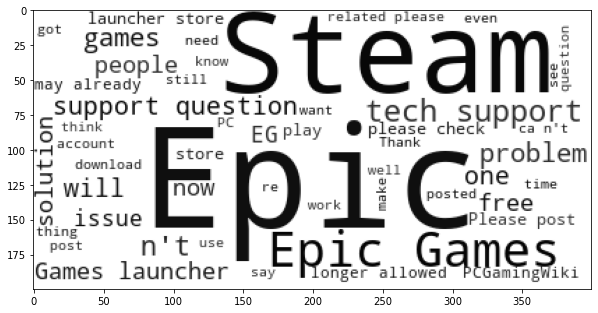

In [12]:
words = df.Reply.str.cat(sep='. ')

stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# Generate word cloud
wc.generate(words)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

In [13]:
# An interesting substring "n't" showed up in the word cloud, I investigated and found
# that it is caused by the 'unlinking' cleaning process
df.Reply.iloc[1]

"Tech support questions are no longer allowed to be posted due to community request ( as of 10-Jun-2020 ) . Please post all your questions on the Epic Games launcher , store and its games in the stickied 'Community Support ' thread . Additionally , if it 's game related , please check out PCGamingWiki as there may already be a solution to your problem !"

In [14]:
# Replace the word "n't" with "not"
df["Reply"]= df["Reply"].str.replace("n't", "not", case = False) 
df.Reply.iloc[1]

"Tech support questions are no longer allowed to be posted due to community request ( as of 10-Jun-2020 ) . Please post all your questions on the Epic Games launcher , store and its games in the stickied 'Community Support ' thread . Additionally , if it 's game related , please check out PCGamingWiki as there may already be a solution to your problem !"

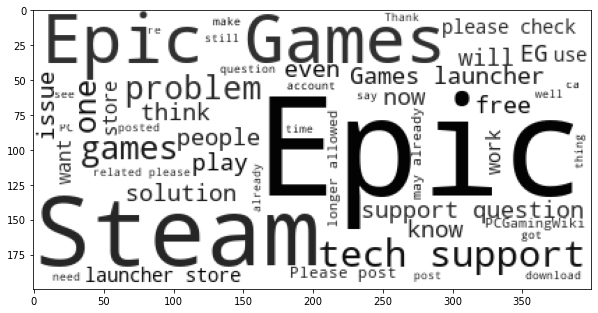

In [15]:
words = df.Reply.str.cat(sep='. ')

stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# Generate word cloud
wc.generate(words)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

## Sentiment Analysis

- ### __Sentiment Classification using Vader package__

In [16]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

# Initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

We can add sentiment scores to words manually if we want

In [18]:
new_words = {
    'Steam' : 0,
    'Epic Games' : 0,
}

sid.lexicon.update(new_words)

In [19]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

In [20]:
df[['vdr neg','vdr neu','vdr pos','vdr compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [21]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound
0,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:15,2.0,0.074,0.737,0.189,0.7712
1,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:26,3.0,0.074,0.737,0.189,0.7712
2,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:08:45,4.0,0.074,0.737,0.189,0.7712


In [22]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound
count,64311.000000,64311.000000,64311.000000,64311.000000,64311.000000,64311.000000
mean,2.174403,4975.184401,0.065858,0.788967,0.140773,0.181163
std,4.799562,2645.753299,0.118999,0.213208,0.186658,0.448638
min,-46.000000,2.000000,0.000000,0.000000,0.000000,-0.999500
25%,1.000000,2758.000000,0.000000,0.704000,0.000000,0.000000
50%,1.000000,5347.000000,0.000000,0.824000,0.091000,0.000000
75%,2.000000,7152.000000,0.090000,1.000000,0.206000,0.551400
max,216.000000,9720.000000,1.000000,1.000000,1.000000,0.999100


- ### Sentiment Classification using Textblob package

In [23]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [24]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [25]:
df[['TB Classification','TB pos','TB neg']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [50]:
df

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg,Classification for Kaggle
0,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:15,2.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral
1,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:26,3.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral
2,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:08:45,4.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral
3,"I 'm a regular shopper , my guess little over ...",2.0,2020-09-18 06:16:40,5.0,0.000,1.000,0.000,0.0000,neg,0.203752,0.796248,negative
4,I started using epic games launcher before the...,1.0,2020-09-18 06:18:07,5.0,0.015,0.866,0.119,0.8424,neg,0.104017,0.895983,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
64306,[ removed ],0.0,2019-05-04 06:00:55,9720.0,0.000,1.000,0.000,0.0000,pos,0.500000,0.500000,neutral
64307,Done : ),1.0,2019-02-11 11:01:47,9720.0,0.000,1.000,0.000,0.0000,pos,0.559524,0.440476,neutral
64308,[ removed ],1.0,2019-04-20 10:11:31,9720.0,0.000,1.000,0.000,0.0000,pos,0.500000,0.500000,neutral
64309,"It would be great , if it was not designed so ...",1.0,2019-05-02 12:46:47,9720.0,0.000,0.709,0.291,0.6249,neg,0.114762,0.885238,positive


In [27]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB pos,TB neg
count,64311.000000,64311.000000,64311.000000,64311.000000,64311.000000,64311.000000,6.431100e+04,6.431100e+04
mean,2.174403,4975.184401,0.065858,0.788967,0.140773,0.181163,5.753843e-01,4.246157e-01
std,4.799562,2645.753299,0.118999,0.213208,0.186658,0.448638,2.617582e-01,2.617582e-01
min,-46.000000,2.000000,0.000000,0.000000,0.000000,-0.999500,1.718876e-07,8.749978e-27
25%,1.000000,2758.000000,0.000000,0.704000,0.000000,0.000000,4.043466e-01,2.187226e-01
50%,1.000000,5347.000000,0.000000,0.824000,0.091000,0.000000,5.678993e-01,4.321007e-01
75%,2.000000,7152.000000,0.090000,1.000000,0.206000,0.551400,7.812774e-01,5.956534e-01
max,216.000000,9720.000000,1.000000,1.000000,1.000000,0.999100,1.000000e+00,9.999998e-01


In [28]:
df['TB Classification'].value_counts()

pos    40924
neg    23387
Name: TB Classification, dtype: int64

- ### Sentiment Classification using Self-Trained Classifier Module for Kaggle

In [29]:
import import_ipynb
%run Kaggle_Trained_Classifier.ipynb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Transform the 'Reply' so it can be passed to the Self-Trained Classifier
Z = vectorizer.transform(df['Reply'])

In [31]:
# Predict the Sentiment based on our reply
predicted2 = nb.predict(Z)

In [32]:
# Look at the size of the prediction result, make sure it is the same as the dataframe's
predicted2.shape

(64311,)

In [33]:
df.shape

(64311, 11)

In [34]:
# Add the Self-Trained Classifier's Classification to the dataframe
df['Classification for Kaggle'] = predicted2

In [35]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg,Classification for Kaggle
0,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:15,2.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral
1,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:54:26,3.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral
2,Tech support questions are no longer allowed t...,1.0,2020-09-18 06:08:45,4.0,0.074,0.737,0.189,0.7712,pos,0.839151,0.160849,neutral


In [36]:
df['Classification for Kaggle'].value_counts()

neutral     37786
negative    14657
positive    11868
Name: Classification for Kaggle, dtype: int64

## Analysis
- ### __Positive / Negative Sentiments Ratio__

Using the Textblob package, we can see that the Epic Games Store reddit has a mixed sentiment response on posts. 36% bad sentimes and 63% good sentiment.

Using our own trained classification module, there seems to be more Negative sentiments compared to Positive ones. 23% Negative response and 18% Positive sentimes. But if we set aside the Neutral Sentimes, this looks like a very mixed sentiment.

In [37]:
df['Classification for Kaggle'].value_counts(normalize=True) * 100

neutral     58.755112
negative    22.790813
positive    18.454075
Name: Classification for Kaggle, dtype: float64

In [38]:
df['TB Classification'].value_counts(normalize=True) * 100

pos    63.634526
neg    36.365474
Name: TB Classification, dtype: float64

- ### Analysing Compound Sentiment Score Overtime

In [39]:
# Importing matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
overTime = df.drop(["Reply","Upvote","Key","vdr neg","vdr neu","vdr pos","TB Classification","TB pos","TB neg","Classification for Kaggle"], axis =1)

In [41]:
overTime.head(5)

,Time,vdr compound
0,2020-09-18 06:54:15,0.7712
1,2020-09-18 06:54:26,0.7712
2,2020-09-18 06:08:45,0.7712
3,2020-09-18 06:16:40,0.0000
4,2020-09-18 06:18:07,0.8424


In [42]:
# Set 'Time' as Index
# This is done to allow grouping by DatetimeIndex
over_time = overTime.set_index(pd.DatetimeIndex(overTime['Time']))

In [43]:
over_time.head()

,Time,vdr compound
Time,,
2020-09-18 06:54:15,2020-09-18 06:54:15,0.7712
2020-09-18 06:54:26,2020-09-18 06:54:26,0.7712
2020-09-18 06:08:45,2020-09-18 06:08:45,0.7712
2020-09-18 06:16:40,2020-09-18 06:16:40,0.0000
2020-09-18 06:18:07,2020-09-18 06:18:07,0.8424


In [44]:
# Group values by Month
g = over_time.groupby(pd.Grouper(freq="M")) 

In [45]:
# Sum the values of each Month
data_sum = g.sum()

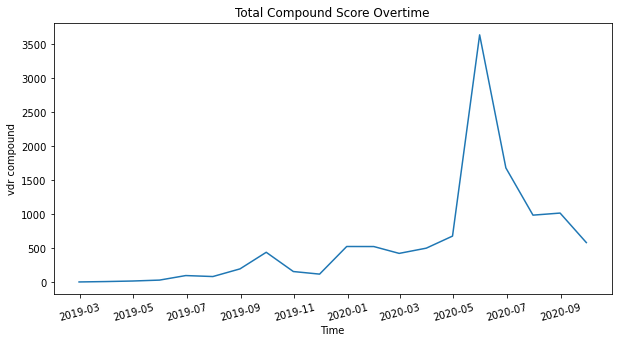

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_sum.index, y="vdr compound", data=data_sum)
plt.xticks(rotation=15)
plt.title('Total Compound Score Overtime')
plt.show()

In [47]:
# Find the average values of each month
data_mean = g.mean()

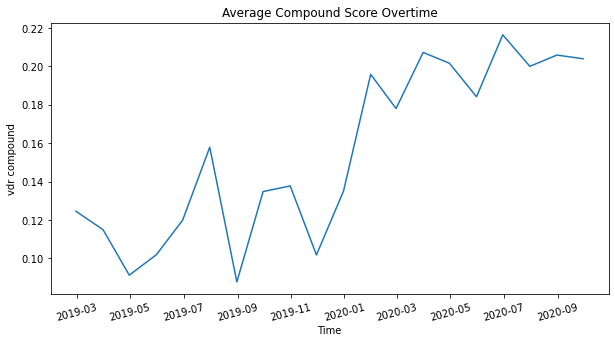

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_mean.index, y="vdr compound", data=data_mean)
plt.xticks(rotation=15)
plt.title('Average Compound Score Overtime')
plt.show()